# Data Scientist - Technical Test
## Task
We ask you to begin creating a prototype model from the dataset below, which consists of an
international online retailer’s transactions from 2010-2011
* To demonstrate your ability to do predictive modeling, demonstrate to us how you would go about forecasting daily sales
    - Given this retailer’s 2010-2011 transactions in the datatest, predict the amount (€) this retailer will sell each day of 2012

## Details
* Dataset: https://archive.ics.uci.edu/ml/datasets/Online+Retail#
* Code must be written in Python

## Submission
* Submit your code via a GitHub repository shared with:
    - Sierra Brader: mist02468 (GitHub)
* This is an open-ended assignment, so the overall approach taken as well as the details of your implementation will be assessed. The specific accuracy of your solution’s predictions is not our primary evaluation criteria (this is not Kaggle), we are more so interested in seeing how you think, how you would approach such a project, and how you go about making technical decisions
* We will discuss your ideas and solution together

# Exploratory Data Analysis and Model Selection

We are going to first explore the dataset to extract some knowledge about the data.

We have one row per item transaction. 

Each transaction is associated to a **Invoice** and **Customer** by two identifiers (`InvoiceNo` and `CustomerID`), this makes a pretty flat dataset.

Each transaction has a `Quantity` of the **goods** and the `UnitPrice`. Each good has a `StockCode`.

In [103]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')

In [3]:
df.shape

(541909, 8)

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Attribute Description
* **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
* **Description:** Product (item) name. Nominal. 
* **Quantity:** The quantities of each product (item) per transaction. Numeric. 
* **InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated. 
* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling. 
* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
* **Country:** Country name. Nominal, the name of the country where each customer resides.

### Invoice Number I

We have **25900 invoices**. 

Each one has a unique identifier and for each invocie we can have multiple transactions. We define a transaction as a sell, return or regularization (we have already seen that there can be transactions with negative values or zero `Quantity` or `UnitPrice`).

Invoices identifiers are not always integers, they can have characters.

All invoices have a unique Customer

In [6]:
df.InvoiceNo.unique().shape

(25900,)

In [7]:
df.InvoiceNo.dtype

dtype('O')

In [8]:
## all invoices have a unique Customer?
all(df.groupby('InvoiceNo').CustomerID.unique().map(lambda x: len(x)) == 1)

True

### Invoice Number II

Invoices can have positive quantities and negative quantities.

* All invoices starting with C have negative quantities, we assume the customer returns the goods
* All invocies starting with A are adjustments
* We have Invoices with integer IDs that have negative quantities. In these cases in 64% of the cases we have a `null` descripition and the rest looks like a free text filled description. Most of the descriptions look like returns of the goods due to items porblems.

In [9]:
df[df.InvoiceNo.map(lambda x: isinstance(x, str))].Quantity.describe()

count     9291.000000
mean       -29.875256
std       1145.602081
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max          1.000000
Name: Quantity, dtype: float64

In [10]:
df[df.InvoiceNo.map(lambda x: isinstance(x, str))][
    df[df.InvoiceNo.map(lambda x: isinstance(x, str))].Quantity >0
]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
df[df.InvoiceNo.map(lambda x: isinstance(x, str))].sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
176390,C551999,22767,TRIPLE PHOTO FRAME CORNICE,-1,2011-05-05 15:53:00,9.95,14911.0,EIRE
383013,C569985,22623,BOX OF VINTAGE JIGSAW BLOCKS,-3,2011-10-06 19:51:00,5.95,15365.0,United Kingdom
70604,C542086,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-25 12:34:00,12.75,18277.0,United Kingdom
320048,C564960,23025,DRAWER KNOB VINTAGE GLASS BALL,-6,2011-08-31 14:24:00,2.08,14525.0,United Kingdom
362540,C568501,22171,3 HOOK PHOTO SHELF ANTIQUE WHITE,-2,2011-09-27 12:13:00,8.50,16713.0,United Kingdom
74269,C542413,22699,ROSES REGENCY TEACUP AND SAUCER,-2,2011-01-27 17:11:00,2.95,16923.0,United Kingdom
215717,C555729,23093,SMALL PARISIENNE HEART PHOTO FRAME,-1,2011-06-06 16:50:00,2.49,13552.0,United Kingdom
236115,C557709,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2011-06-22 10:39:00,4.95,15840.0,United Kingdom
38946,C539603,22197,SMALL POPCORN HOLDER,-2,2010-12-20 14:05:00,0.85,14911.0,EIRE
186015,C552841,22841,ROUND CAKE TIN VINTAGE GREEN,-2,2011-05-11 14:28:00,7.95,15827.0,United Kingdom


In [12]:
df[df.InvoiceNo.map(lambda x: isinstance(x, int))].Quantity.describe()

count    532618.000000
mean         10.240024
std         159.593999
min       -9600.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [13]:
df[df.InvoiceNo.map(lambda x: isinstance(x, int))][
    df[df.InvoiceNo.map(lambda x: isinstance(x, int))].Quantity<0
]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [14]:
pd.set_option('display.max_rows', 500)

pd.DataFrame(
    {
        'count': df[df.InvoiceNo.map(lambda x: isinstance(x, int))][
    df[df.InvoiceNo.map(lambda x: isinstance(x, int))].Quantity<0
].Description.value_counts(dropna=False),
        'pct': df[df.InvoiceNo.map(lambda x: isinstance(x, int))][
    df[df.InvoiceNo.map(lambda x: isinstance(x, int))].Quantity<0
].Description.value_counts(dropna=False, normalize=True)
    }
)


,count,pct
NaN,862,0.645210
check,120,0.089820
damages,45,0.033683
damaged,42,0.031437
?,41,0.030689
sold as set on dotcom,20,0.014970
Damaged,14,0.010479
thrown away,9,0.006737
"Unsaleable, destroyed.",9,0.006737
??,7,0.005240


### Stock Code I

There are 4070 different items. 
* Most of them (89%) have a 5 digit id
* A 9% has 6 digit id
* All items have an id
* Looks like that 6 digit ids are color variations of the same good (although is not always the case)
* It also looks like there's no patern in the code. I would expect some kind of code aggregation as for example, all lights starting with 89 code.

In [15]:
df.StockCode.unique().size

4070

In [16]:
(df.StockCode.isnull()==True).sum()

0

In [17]:
pd.DataFrame(
    {
        'count': df.StockCode.map(lambda x: len(str(x))).value_counts(),
        'pct':  df.StockCode.map(lambda x: len(str(x))).value_counts(normalize=True)
    }
)

,count,pct
5,487036,0.898741
6,51488,0.095012
4,1276,0.002355
1,715,0.001319
3,710,0.001310
7,390,0.000720
2,144,0.000266
12,71,0.000131
9,48,0.000089
8,31,0.000057


In [18]:
df[df.StockCode.map(lambda x: len(str(x)))==5].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
81049,543107,22606,WOODEN SKITTLES GARDEN SET,2,2011-02-03 12:27:00,15.95,13800.0,United Kingdom
475474,576893,22549,PICTURE DOMINOES,12,2011-11-17 08:29:00,1.45,12481.0,Germany
307504,563920,23034,DRAWER KNOB CERAMIC BLACK,12,2011-08-21 14:00:00,1.45,16407.0,United Kingdom
272110,560732,22977,DOLLY GIRL CHILDRENS EGG CUP,1,2011-07-20 14:55:00,1.25,14056.0,United Kingdom
102936,545045,22119,PEACE WOODEN BLOCK LETTERS,3,2011-02-27 11:40:00,6.95,15708.0,United Kingdom


In [19]:
df[df.StockCode.map(lambda x: len(str(x)))==6].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
77887,542791,47566B,TEA TIME PARTY BUNTING,3,2011-02-01 10:47:00,4.65,15039.0,United Kingdom
31902,539019,84509A,SET OF 4 ENGLISH ROSE PLACEMATS,4,2010-12-15 14:12:00,3.75,17551.0,United Kingdom
193904,553546,84519B,CARROT CHARLIE+LOLA COASTER SET,24,2011-05-17 15:42:00,1.25,12415.0,Australia
391878,570685,72801D,4 SKY BLUE DINNER CANDLES,2,2011-10-11 16:25:00,1.25,13208.0,United Kingdom
36119,539437,85039C,S/4 BLACK MINI ROSE CANDLE IN BOWL,1,2010-12-17 14:54:00,1.66,NaN,United Kingdom


In [20]:
df[df.StockCode.map(lambda x: len(str(x)))==4].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
319701,564862,POST,POSTAGE,1,2011-08-31 10:24:00,145.0,12678.0,France
393060,570793,POST,POSTAGE,8,2011-10-12 12:08:00,40.0,12444.0,Norway
301486,563288,POST,POSTAGE,4,2011-08-15 12:53:00,18.0,12656.0,France
511361,579492,POST,POSTAGE,3,2011-11-29 15:23:00,18.0,12670.0,France
428278,573417,POST,POSTAGE,1,2011-10-31 08:56:00,18.0,12581.0,Germany


In [21]:
df[df.StockCode.map(lambda x: len(str(x)))==1].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
135649,547906,M,Manual,2,2011-03-28 12:13:00,0.50,14410.0,United Kingdom
277946,C561198,M,Manual,-35,2011-07-25 14:45:00,1.25,16161.0,United Kingdom
114654,546035,M,Manual,1,2011-03-09 09:50:00,7.95,12924.0,United Kingdom
96685,C544580,S,SAMPLES,-1,2011-02-21 14:25:00,9.74,NaN,United Kingdom
186433,C552863,M,Manual,-1,2011-05-11 16:52:00,5.10,13012.0,United Kingdom


In [22]:
df[df.StockCode.map(lambda x: len(str(x)))==3].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
87024,543629,DOT,DOTCOM POSTAGE,1,2011-02-10 15:55:00,208.92,NaN,United Kingdom
130050,547400,DOT,DOTCOM POSTAGE,1,2011-03-22 16:56:00,116.67,NaN,United Kingdom
161024,550470,DOT,DOTCOM POSTAGE,1,2011-04-18 13:49:00,2.29,NaN,United Kingdom
487150,577768,DOT,DOTCOM POSTAGE,1,2011-11-21 15:18:00,523.77,NaN,United Kingdom
57125,541132,DOT,DOTCOM POSTAGE,1,2011-01-14 10:17:00,127.54,NaN,United Kingdom


In [23]:
df[df.StockCode.map(lambda x: len(str(x)))==7].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
28628,538651,15056BL,EDWARDIAN PARASOL BLACK,1,2010-12-13 15:07:00,5.95,15311.0,United Kingdom
11410,537240,15056BL,EDWARDIAN PARASOL BLACK,3,2010-12-06 10:08:00,5.95,NaN,United Kingdom
58297,541225,15056BL,EDWARDIAN PARASOL BLACK,2,2011-01-14 14:47:00,5.95,14099.0,United Kingdom
267694,560359,15056BL,EDWARDIAN PARASOL BLACK,2,2011-07-18 11:47:00,5.95,14159.0,United Kingdom
5547,536865,15056bl,EDWARDIAN PARASOL BLACK,2,2010-12-03 11:28:00,12.72,NaN,United Kingdom


In [24]:
df[df.StockCode.map(lambda x: len(str(x)))==2].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
330175,565916,C2,CARRIAGE,1,2011-09-07 16:00:00,50.0,14156.0,EIRE
467854,576371,C2,CARRIAGE,1,2011-11-15 08:07:00,50.0,14911.0,EIRE
44302,C540164,C2,CARRIAGE,-1,2011-01-05 12:02:00,50.0,14911.0,EIRE
464606,576141,C2,CARRIAGE,1,2011-11-14 10:47:00,50.0,14911.0,EIRE
116010,546172,C2,CARRIAGE,1,2011-03-10 10:32:00,50.0,14156.0,EIRE


In [25]:
df[df.StockCode.map(lambda x: len(str(x)))==9].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
124787,C546989,AMAZONFEE,AMAZON FEE,-1,2011-03-18 12:59:00,5225.03,NaN,United Kingdom
287150,C562086,AMAZONFEE,AMAZON FEE,-1,2011-08-02 12:27:00,6721.37,NaN,United Kingdom
239250,C558036,AMAZONFEE,AMAZON FEE,-1,2011-06-24 12:31:00,5791.18,NaN,United Kingdom
287103,C562062,AMAZONFEE,AMAZON FEE,-1,2011-08-02 12:17:00,4575.64,NaN,United Kingdom
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2011-03-07 17:22:00,3.29,NaN,United Kingdom


In [26]:
df[df.StockCode.map(lambda x: len(str(x)))==12].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
163439,550542,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-04-19 11:37:00,8.33,NaN,United Kingdom
96715,C544584,BANK CHARGES,Bank Charges,-1,2011-02-21 14:52:00,109.84,NaN,United Kingdom
239899,558068,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-06-24 15:51:00,16.67,NaN,United Kingdom
96675,C544575,BANK CHARGES,Bank Charges,-1,2011-02-21 13:58:00,134.76,NaN,United Kingdom
94054,544323,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2011-02-17 15:51:00,25.00,NaN,United Kingdom


In [27]:
df[df.StockCode.map(lambda x: len(str(x)))==8].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
40052,539718,DCGS0070,CAMOUFLAGE DOG COLLAR,1,2010-12-21 13:06:00,12.72,NaN,United Kingdom
178669,552234,DCGSSBOY,BOYS PARTY BAG,7,2011-05-06 16:01:00,3.29,NaN,United Kingdom
279256,561254,DCGS0067,ebay,-11,2011-07-26 11:52:00,0.00,NaN,United Kingdom
518711,580115,DCGSSBOY,BOYS PARTY BAG,1,2011-12-01 16:22:00,3.29,NaN,United Kingdom
279254,561252,DCGS0069,ebay,-5,2011-07-26 11:52:00,0.00,NaN,United Kingdom


### Stock Code II

We see that there is a long tail of less frequent sold items.

Also we see that there are big batches of cancelations or returns. When this happens one can expect free text entries in the description.

In [28]:
top10_sold_items = df.groupby('StockCode').Quantity.sum().sort_values(ascending=False)[:10]
top10_sold_items

pd.concat(
    [
        top10_sold_items,
        top10_sold_items/df.Quantity.sum()*100,
        df.groupby('StockCode').first().loc[
            top10_sold_items.index,
            ['Description', 'UnitPrice']
        ],
    ],
    axis=1
)

,Quantity,Quantity,Description,UnitPrice
StockCode,,,,
22197,56450,1.090516,SMALL POPCORN HOLDER,0.72
84077,53847,1.040230,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.29
85099B,47363,0.914971,JUMBO BAG RED RETROSPOT,1.65
85123A,38830,0.750128,WHITE HANGING HEART T-LIGHT HOLDER,2.55
84879,36221,0.699727,ASSORTED COLOUR BIRD ORNAMENT,1.69
21212,36039,0.696211,PACK OF 72 RETROSPOT CAKE CASES,0.42
23084,30646,0.592027,RABBIT NIGHT LIGHT,2.08
22492,26437,0.510717,MINI PAINT SET VINTAGE,0.65
22616,26315,0.508360,PACK OF 12 LONDON TISSUES,0.29


<AxesSubplot:xlabel='StockCode'>

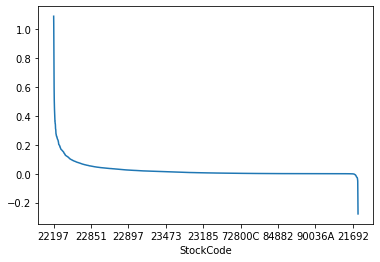

In [29]:
(df.groupby('StockCode').Quantity.sum()/df.Quantity.sum()*100).sort_values(ascending=False).plot()

In [30]:
bottom10_sold_items = df.groupby('StockCode').Quantity.sum().sort_values(ascending=True)[:10]
bottom10_sold_items

StockCode
23005     -14418
23003      -8516
72140F     -5368
79323W     -4838
79323LP    -2618
72732      -2472
23059      -2376
79323P     -2007
79323B     -1671
22618      -1632
Name: Quantity, dtype: int64

In [31]:
pd.concat(
    [
        bottom10_sold_items,
        df.groupby('StockCode').first().loc[
            bottom10_sold_items.index,
            ['Description', 'UnitPrice']
        ],
    ],
    axis=1
)

,Quantity,Description,UnitPrice
StockCode,,,
23005,-14418,TRAVEL CARD WALLET I LOVE LONDON,0.42
23003,-8516,TRAVEL CARD WALLET VINTAGE ROSE,0.42
72140F,-5368,throw away,0.00
79323W,-4838,WHITE CHERRY LIGHTS,6.75
79323LP,-2618,"Unsaleable, destroyed.",0.00
72732,-2472,thrown away-can't sell,0.00
23059,-2376,Thrown away-rusty,0.00
79323P,-2007,PINK CHERRY LIGHTS,6.75
79323B,-1671,BLACK CHERRY LIGHTS,6.75


### Stock Code III

We see that items can have a variable `UnitPrice`.

In [32]:
top20_expensive_max_items = df.groupby('StockCode').UnitPrice.max().sort_values(ascending=False)[:20]
top20_expensive_min_items = df.set_index('StockCode').loc[
    top20_expensive_max_items.index,:].groupby('StockCode').UnitPrice.min().sort_values(ascending=False)

top20_expensive_min_items.name = 'MinUnitPrice'
top20_expensive_max_items.name = 'MaxUnitPrice'

In [33]:
pd.concat(
    [
        top20_expensive_max_items,
        top20_expensive_min_items,
        df.groupby('StockCode').first().loc[
            top20_expensive_max_items.index,
            ['Description', 'UnitPrice']
        ],
    ],
    axis=1
)

,MaxUnitPrice,MinUnitPrice,Description,UnitPrice
StockCode,,,,
M,38970.00,0.000,Manual,1.25
AMAZONFEE,17836.46,1.000,AMAZON FEE,1.00
B,11062.06,-11062.060,Adjust bad debt,11062.06
POST,8142.75,0.000,POSTAGE,18.00
DOT,4505.17,0.000,DOTCOM POSTAGE,569.77
D,1867.86,0.010,Discount,27.50
CRUK,1100.44,1.600,CRUK Commission,1.60
BANK CHARGES,1050.15,0.001,Bank Charges,15.00
22502,649.50,0.000,PICNIC BASKET WICKER SMALL,5.95


### Description

It is a free text field with the description. 

We have already found some cases where it is null or it has unconsistent entries. 

In [34]:
df.Description

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 541909, dtype: object

In [35]:
def flatten(x):
    flat_list = []
    for l in x:
        if isinstance(l, str):
            # we strip the description because we have tailing blank spaces
            flat_list.extend(l.strip(' ').split(' '))
            
    return flat_list

all_words = flatten(df.Description.unique().tolist())

In [36]:
pd.Series(all_words).value_counts()[:30]

SET           324
PINK          301
OF            241
HEART         237
VINTAGE       220
BLUE          214
RED           198
              177
BAG           171
CHRISTMAS     157
GLASS         156
BOX           135
WHITE         132
DESIGN        129
HOLDER        118
FLOWER        115
SMALL         115
METAL         111
LARGE         106
HANGING       104
GREEN         102
DECORATION    101
ROSE          100
NECKLACE      100
BLACK          98
WALL           97
RETROSPOT      96
3              95
CANDLE         94
T-LIGHT        90
dtype: int64

In [37]:
# we can't see a pattern in stock code
df[df.Description.str.contains('RETROSPOT').fillna(False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
33,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2010-12-01 08:45:00,2.95,12583.0,France
90,536378,84997B,RED 3 PIECE RETROSPOT CUTLERY SET,12,2010-12-01 09:37:00,3.75,14688.0,United Kingdom
93,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 09:37:00,1.65,14688.0,United Kingdom
95,536378,22352,LUNCH BOX WITH CUTLERY RETROSPOT,6,2010-12-01 09:37:00,2.55,14688.0,United Kingdom
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688.0,United Kingdom
...,...,...,...,...,...,...,...,...
541857,581580,22567,20 DOLLY PEGS RETROSPOT,1,2011-12-09 12:20:00,1.45,12748.0,United Kingdom
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom
541893,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom


### Quantity

We can see that almost a 80% of the transactions is with more than 10 units. Also, around a 48% of the transactions are in batches of 25 items or more. This shows that there are retailers buying big quantities of goods. 

This might be important for forecasting sells.



In [38]:
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [39]:
df.Quantity.value_counts().sort_index()

-80995    1
-74215    1
-9600     2
-9360     1
-9058     1
         ..
 4800     1
 5568     1
 12540    1
 74215    1
 80995    1
Name: Quantity, Length: 722, dtype: int64

In [40]:
pos_qty = df[df.Quantity>0].Quantity
pos_qty_freq = pos_qty.value_counts().sort_index()
pos_qty_freq = pos_qty_freq.reset_index().rename(columns={'Quantity': 'NumSells', 'index': 'Quantity'})

In [41]:
pos_qty_freq['Volume'] = pos_qty_freq.Quantity*pos_qty_freq.NumSells

In [42]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 25), (25, pos_qty_freq.Quantity.max())])
pos_qty_freq['VolumeRange'] = pd.cut(pos_qty_freq.Quantity, bins=bins)

In [43]:
pos_qty_freq = pd.concat(
    [
        pos_qty_freq.groupby('VolumeRange').sum(),
        pos_qty_freq.groupby('VolumeRange').sum().Volume/pos_qty_freq.groupby('VolumeRange').sum().Volume.sum()
    ],
    axis=1
)
pos_qty_freq.columns = ['Quantity', 'NumSells', 'VolumeAbs', 'VolumePct']

In [44]:
pos_qty_freq.loc[:,['NumSells', 'VolumeAbs', 'VolumePct']]

,NumSells,VolumeAbs,VolumePct
VolumeRange,,,
"(0, 10]",398654,1247820,0.220425
"(10, 25]",105141,1695071,0.299431
"(25, 80995]",27490,2718090,0.480145


### Unit Price

We can oberve that most of the items have prices below 10 units (I guess is GBP). However we should do a better analysis after cleaning the dataset.

In [45]:
df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [49]:
df['Total'] = df.Quantity*df.UnitPrice

In [50]:
df.UnitPrice.quantile(0.9) # 90th percentile
# 89.10000000000001

7.950000000000001

In [52]:
df_volume = df.groupby('StockCode').Total.sum().sort_values()

In [53]:
pd.concat(
    [
        df.set_index('StockCode').loc[
            df_volume.index,
            ['Description', 'UnitPrice']
        ].groupby('StockCode').first(),
        df_volume
    ],
    axis=1
).sort_values('Total', ascending=False)[:20]

,Description,UnitPrice,Total
StockCode,,,
DOT,DOTCOM POSTAGE,569.77,206245.48
22423,REGENCY CAKESTAND 3 TIER,10.95,164762.19
47566,PARTY BUNTING,9.32,98302.98
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,97894.50
85099B,JUMBO BAG RED RETROSPOT,1.65,92356.03
23084,RABBIT NIGHT LIGHT,2.08,66756.59
POST,POSTAGE,18.00,66230.64
22086,PAPER CHAIN KIT 50'S CHRISTMAS,2.55,63791.94
84879,ASSORTED COLOUR BIRD ORNAMENT,1.69,58959.73


### Customer Id

We can see that there are `nulls` in the `CostumerId` variable. In my opinion it shouldn't be a problem to predict sells. The 

In [54]:
df.CustomerID.unique().size

4373

In [55]:
(df.CustomerID.isnull()==True).sum()/df.shape[0]

0.249266943342886

In [56]:
df[df.CustomerID.isnull()].sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
392292,570690,22572,ROCKING HORSE GREEN CHRISTMAS,3,2011-10-11 16:37:00,1.63,NaN,United Kingdom,4.89
512122,579508,22133,PINK LOVE HEART SHAPE CUP,2,2011-11-29 16:33:00,1.63,NaN,United Kingdom,3.26
219042,556082,22212,FOUR HOOK WHITE LOVEBIRDS,1,2011-06-08 15:22:00,4.13,NaN,United Kingdom,4.13
539588,581439,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,2,2011-12-08 16:30:00,4.13,NaN,United Kingdom,8.26
268758,560434,21166,COOK WITH WINE METAL SIGN,1,2011-07-18 15:56:00,4.13,NaN,United Kingdom,4.13
178228,552229,21714,CITRONELLA CANDLE GARDEN POT,1,2011-05-06 15:40:00,2.46,NaN,United Kingdom,2.46
507849,579187,23521,WALL ART CAT AND BIRD,1,2011-11-28 15:31:00,5.79,NaN,United Kingdom,5.79
512087,579508,21967,PACK OF 12 SKULL TISSUES,2,2011-11-29 16:33:00,0.83,NaN,United Kingdom,1.66
62787,541516,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-18 17:34:00,1.25,NaN,United Kingdom,1.25
61085,541423,22638,SET OF 4 NAPKIN CHARMS CROWNS,4,2011-01-17 17:54:00,1.63,NaN,United Kingdom,6.52


In [69]:
costumer_volumes = df.groupby('CustomerID').agg({'Total': 'sum'}).sort_values('Total', ascending=False)

In [70]:
costumer_volumes

,Total
CustomerID,
14646.0,279489.02
18102.0,256438.49
17450.0,187482.17
14911.0,132572.62
12415.0,123725.45
...,...
12503.0,-1126.00
17603.0,-1165.30
14213.0,-1192.20


In [71]:
costumer_volumes['pct'] = costumer_volumes['Total']/costumer_volumes['Total'].sum()
costumer_volumes['pct_cumsum'] = (costumer_volumes['Total']/costumer_volumes['Total'].sum()).cumsum()

In [72]:
costumer_volumes.iloc[:200]

,Total,pct,pct_cumsum
CustomerID,,,
14646.0,279489.02,0.033673,0.033673
18102.0,256438.49,0.030896,0.064569
17450.0,187482.17,0.022588,0.087157
14911.0,132572.62,0.015972,0.103130
12415.0,123725.45,0.014907,0.118036
14156.0,113384.14,0.013661,0.131697
17511.0,88125.38,0.010617,0.142314
16684.0,65892.08,0.007939,0.150253
13694.0,62653.10,0.007549,0.157801


### Invoice Date

In the plots below we see 3 kind of plots:
* One ploting the number of transactions per day
* Another one plotting the number of orders per day
* The last one with the volume per day

In [73]:
df['InvoiceDay'] = df.InvoiceDate.map(lambda x: f'{x.year}-{x.month:02d}-{x.day:02d}-{x.weekday():02d}')

<AxesSubplot:>

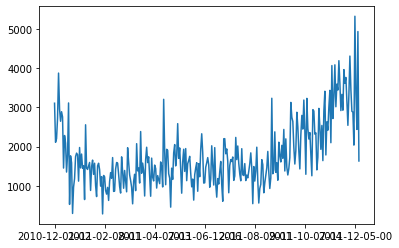

In [74]:
df.InvoiceDay.value_counts().sort_index().plot()

<AxesSubplot:>

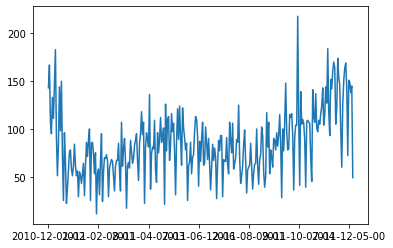

In [75]:
df.groupby('InvoiceNo').InvoiceDay.first().value_counts().sort_index().plot()

<AxesSubplot:xlabel='InvoiceDay'>

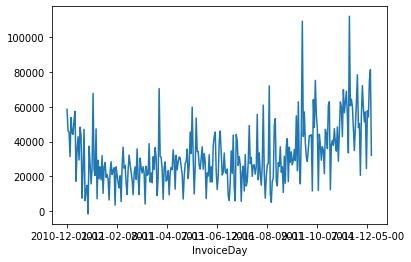

In [76]:
df.groupby('InvoiceDay').Total.sum().sort_index().plot()

In [77]:
df.groupby('InvoiceDay').Total.sum().describe()

count       305.000000
mean      31959.829292
std       17414.261664
min       -1566.230000
25%       20728.140000
50%       27978.410000
75%       42912.400000
max      112141.110000
Name: Total, dtype: float64

In [78]:
df['WeekNumber'] = df.InvoiceDate.map(lambda x: x.isocalendar()[1])
df['Year'] = df.InvoiceDate.map(lambda x: x.year)
df['Month'] = df.InvoiceDate.map(lambda x: x.month)
df['WeekDayName'] = df.InvoiceDate.map(lambda x: x.day_name().lower())
df['WeekDayNum'] = df.InvoiceDate.map(lambda x: x.weekday())

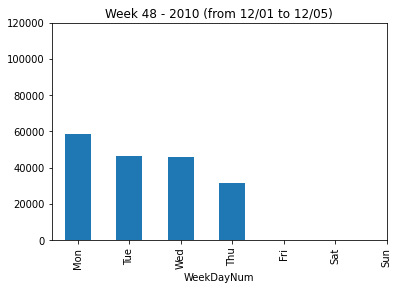

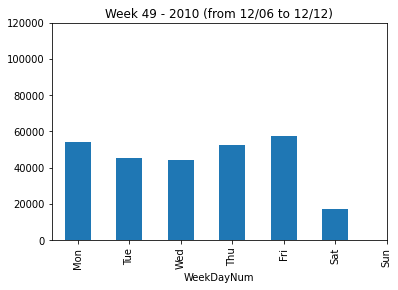

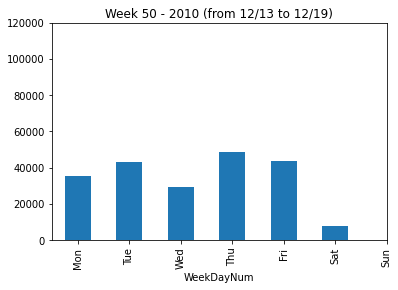

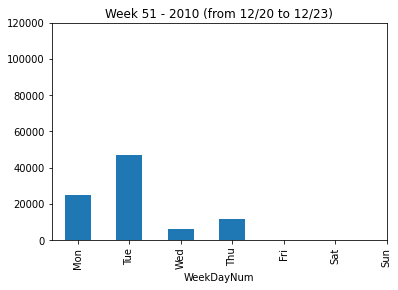

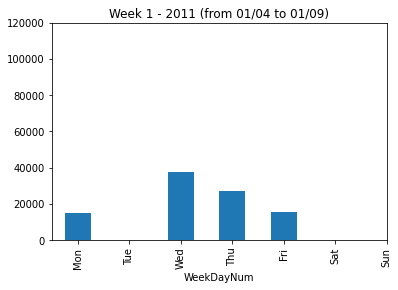

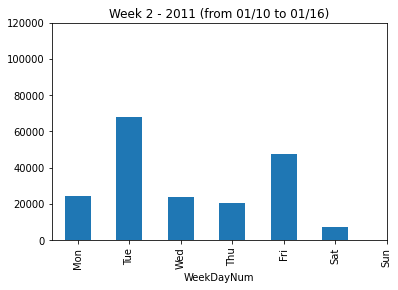

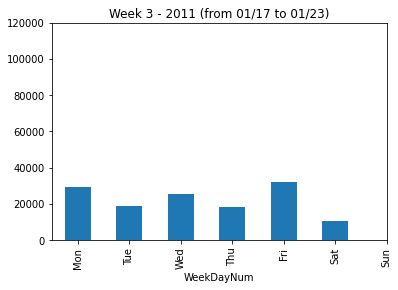

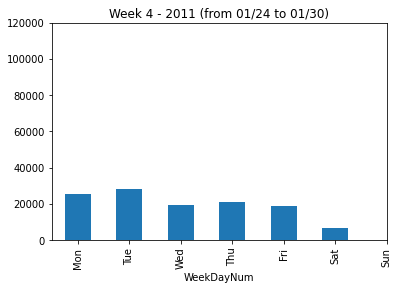

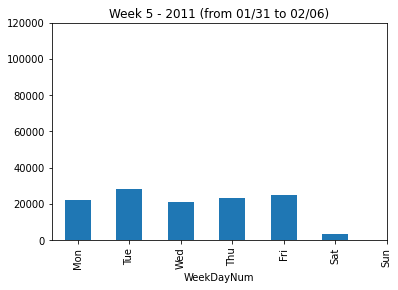

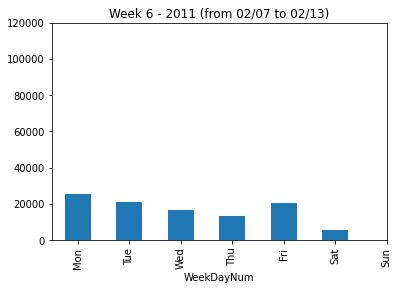

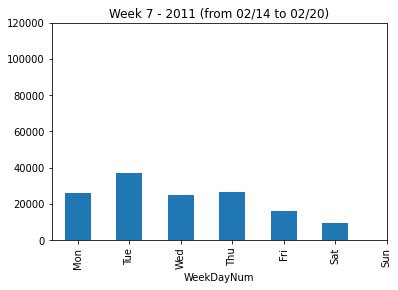

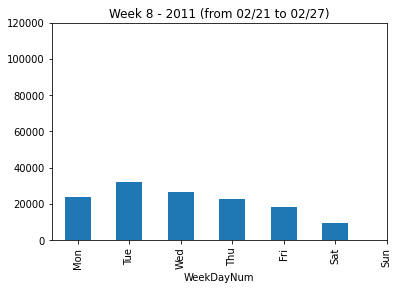

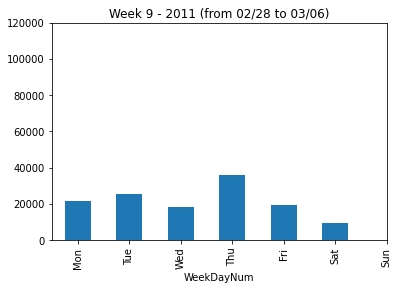

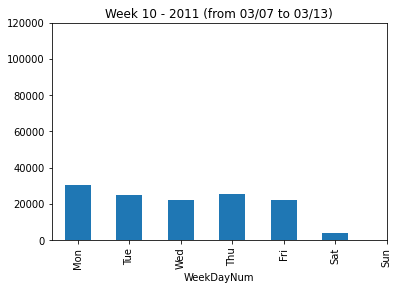

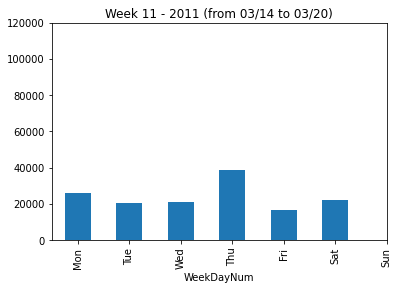

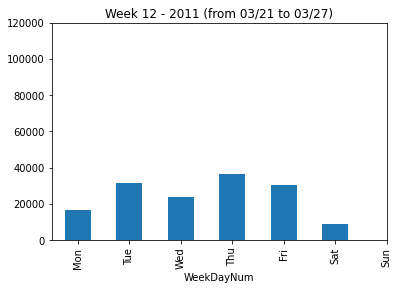

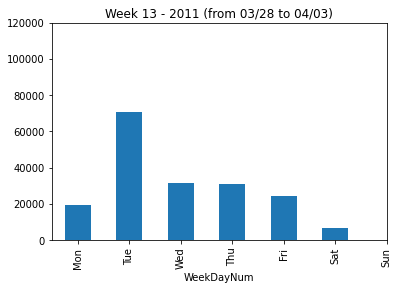

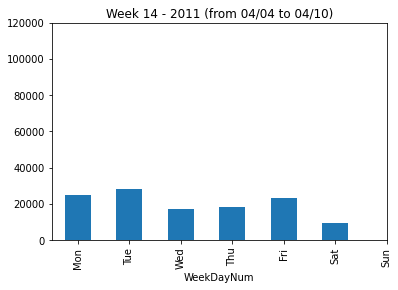

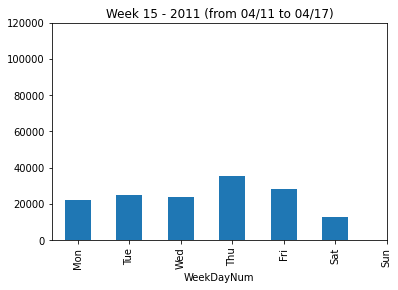

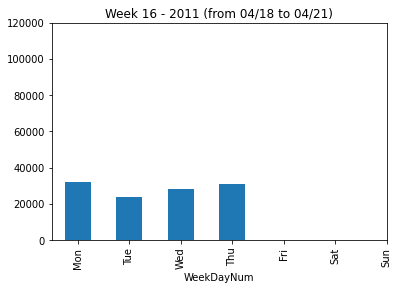

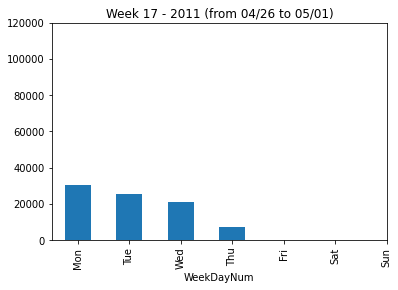

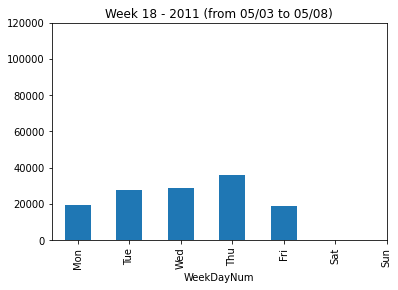

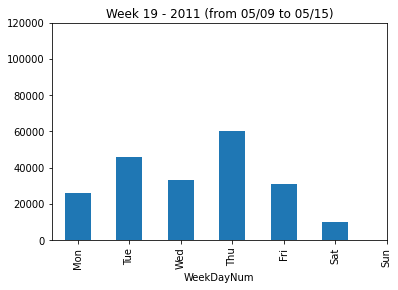

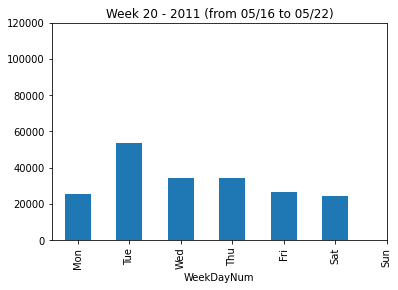

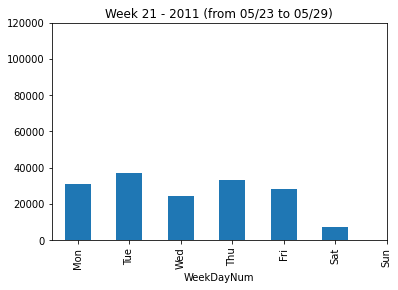

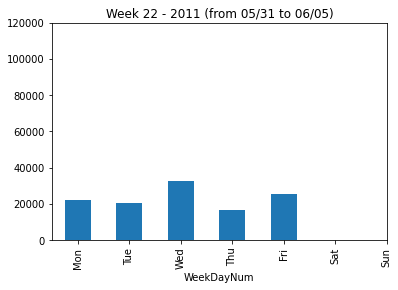

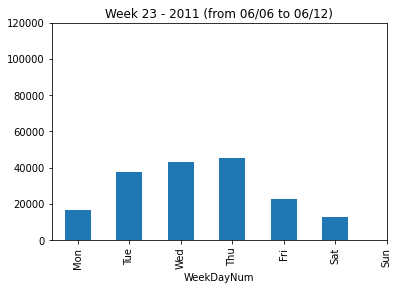

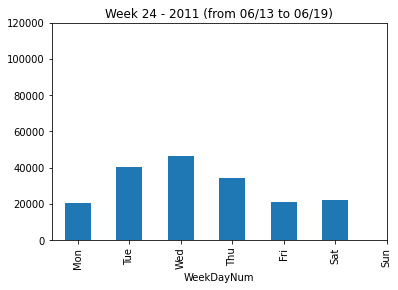

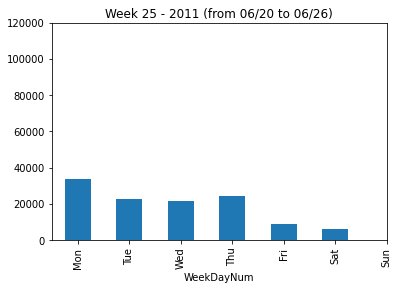

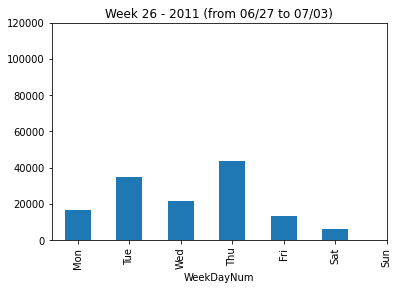

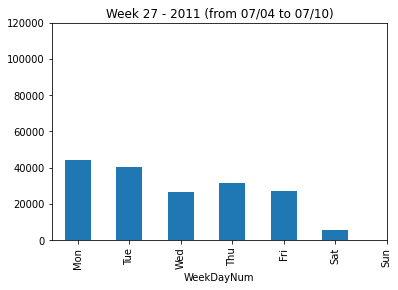

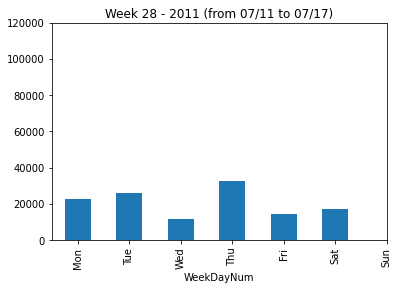

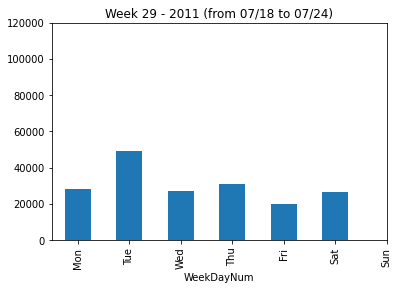

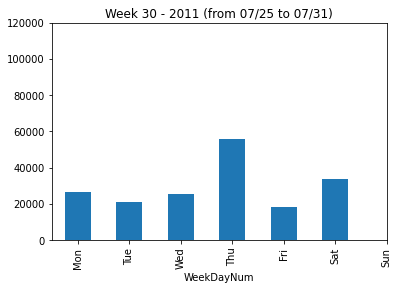

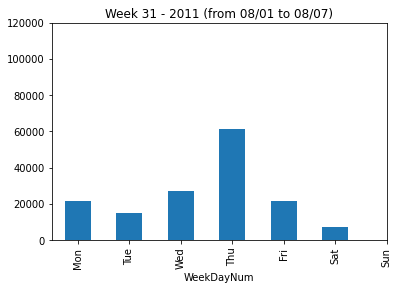

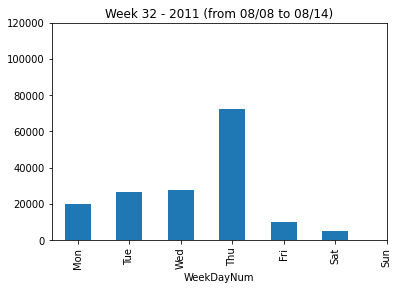

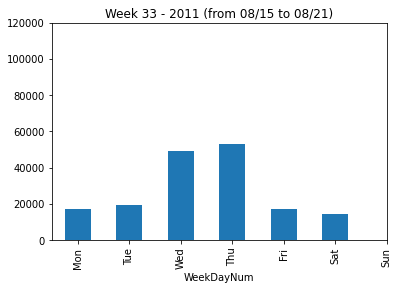

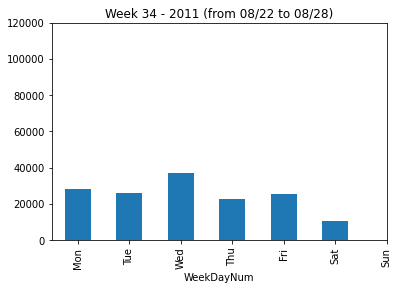

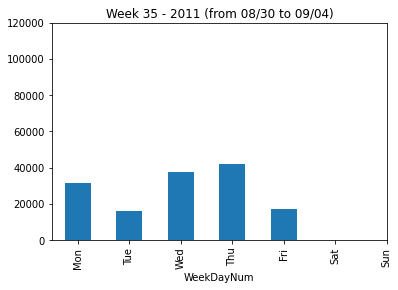

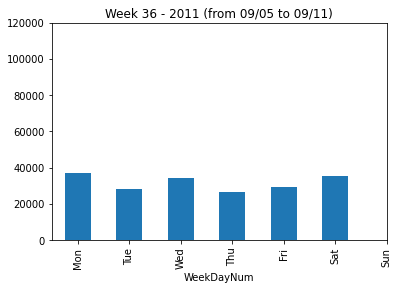

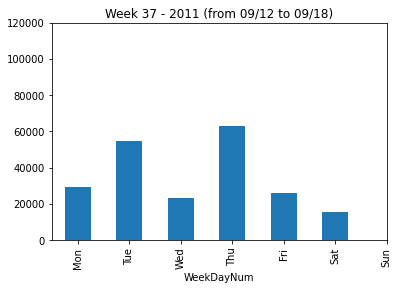

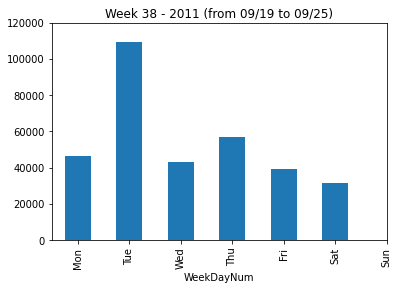

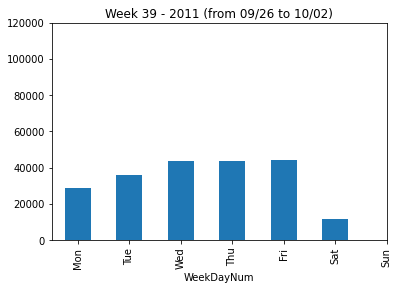

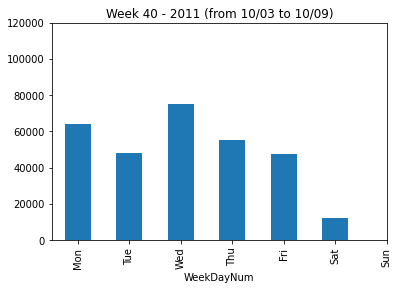

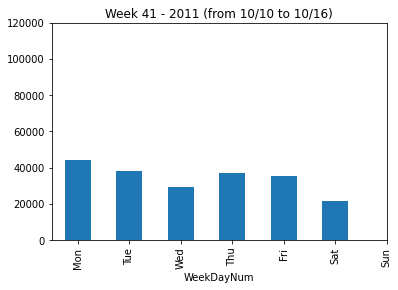

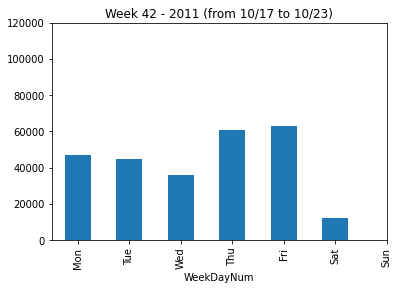

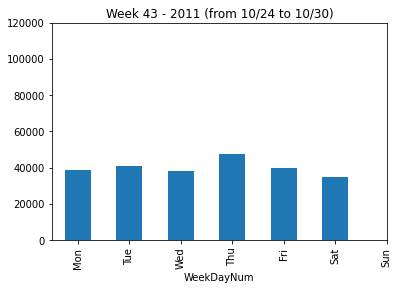

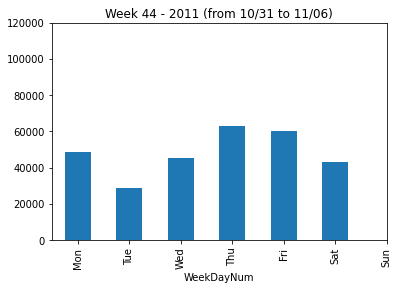

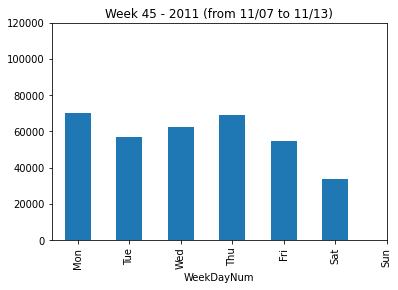

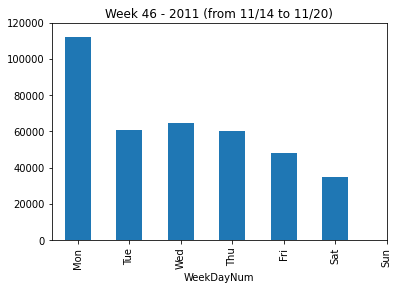

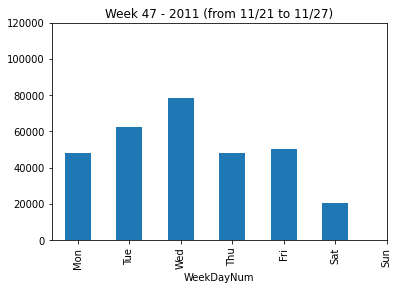

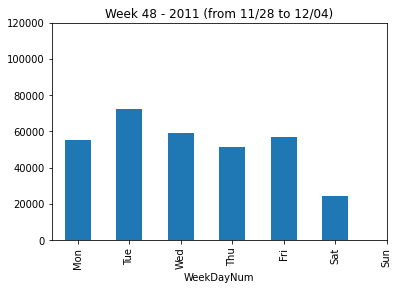

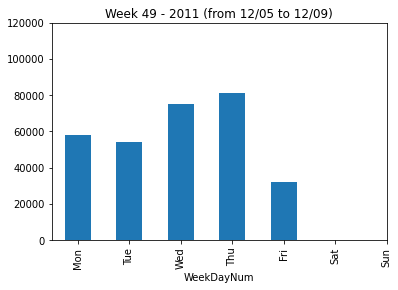

In [80]:
import matplotlib.pyplot as plt

for weeknum_year_tuple in df.set_index(['WeekNumber', 'Year']).index.unique().tolist():
#     print(weeknum_year_tuple)
    week_df = df[(df.WeekNumber == weeknum_year_tuple[0]) & (df.Year == weeknum_year_tuple[1])]
    start_day = '/'.join(week_df.InvoiceDay.sort_values().iloc[0].split('-')[1:3])
    end_day = '/'.join(week_df.InvoiceDay.sort_values().iloc[-1].split('-')[1:3])
    week_df.groupby('WeekDayNum').Total.sum().sort_index().plot(
        kind='bar', 
        title=f'Week {weeknum_year_tuple[0]} - {weeknum_year_tuple[1]} (from {start_day} to {end_day})',
        ylim=(0,120000)
    )
    plt.xticks((0, 1, 2, 3, 4, 5, 6), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
    plt.show()
    plt.close()

### Country

Most of the Invoices (90%) are from the UK, and also most of the users.

In [81]:
pd.DataFrame(
    {
    'count': df.groupby('InvoiceNo').Country.first().value_counts(),
    'pct': df.groupby('InvoiceNo').Country.first().value_counts()/df.groupby('InvoiceNo').Country.first().value_counts().sum()
    }
).head(10)

,count,pct
United Kingdom,23494,0.907104
Germany,603,0.023282
France,461,0.017799
EIRE,360,0.013900
Belgium,119,0.004595
Spain,105,0.004054
Netherlands,101,0.003900
Switzerland,74,0.002857
Portugal,71,0.002741
Australia,69,0.002664


In [82]:
pd.DataFrame(
    {
    'count': df.groupby('CustomerID').Country.first().value_counts(),
    'pct': df.groupby('CustomerID').Country.first().value_counts()/df.groupby('CustomerID').Country.first().value_counts().sum()
    }
).head(10)

,count,pct
United Kingdom,3950,0.903477
Germany,95,0.021729
France,87,0.019899
Spain,29,0.006633
Belgium,24,0.005489
Switzerland,20,0.004575
Portugal,19,0.004346
Italy,15,0.003431
Finland,12,0.002745
Norway,10,0.002287


### Summary of the EDA

In my opinion it is a pretty complex dataset with rather small amount of data.
* We have seen that we have data mainly from 2011 and 3 months from 2010
* Data has to be cleaned, as sometimes it is not consistent and we do have other transactions apart from sells
* We see that the data comes from a seller that mainly sells to retailers
* Also, almost the 50% of the volume comes from 200 users, who spend more than 6000GBP per year
* Most of the costumers and orders come from the UK (90%)
* There's no clear weekly/monthly pattern 

### Data Cleaning

Based on our observations we're going to clean the dataset in order to proceed with further analysis. We're going to take the following actions:

##### Invoice Number
* Drop Cancelations and Adjustments: we want to focus on sells, so we're going to drop all cancelations and adjustments

##### Stock Code
* Drop Non-Good Stock codes: we want to detect all these items that are not goods
* Aggregate same Description with different Stock Code

##### Quantity
* We are going to leave out negative and zero quantities
* Detect outliers and drop

#### UnitPrice
* We are going to leave out negative and zero quantities

In [83]:
new_df = df[df.InvoiceNo.map(lambda x: not (str(x).startswith('C') or str(x).startswith('A')))]

In [84]:
new_df = new_df[new_df.Quantity>0]

In [85]:
new_df = new_df[new_df.UnitPrice>0]

In [86]:
# drop len 12
new_df = new_df[new_df.StockCode.map(lambda x: len(str(x))) != 12]

# drop POST
new_df = new_df[new_df.StockCode != 'POST']

# drop AMAZONFEE
new_df = new_df[new_df.StockCode != 'AMAZONFEE']

# drop CARRIAGE
new_df = new_df[new_df.StockCode != 'CARRIAGE']

# drop POSTAGE
new_df = new_df[new_df.StockCode != 'DOT']

In [87]:
# stock code to lower
new_df.StockCode = new_df.StockCode.map(lambda x: str(x).lower())

# find unique Descriptions with more than one stock code
descr_stock_code = new_df.groupby('Description').StockCode.unique()
descr_stock_code[descr_stock_code.map(lambda x: len(x)) != 1]

# create a mapping with one of the stock codes
duplicated_stock_code_map = descr_stock_code[
    descr_stock_code.map(lambda x: len(x)) != 1
].map(lambda x: x[0]).to_dict()

# save old and reasign new StockCode
new_df['OldStockCode'] = new_df['StockCode']
new_df['StockCode'] = new_df.apply(
    lambda x: duplicated_stock_code_map.get(x['Description'], x['StockCode']), 
    axis=1
)

### Features

* **Total:** We create a new variable named **Total** which basically is $Quantity*UnitPrice$
* **Weekday:** Day of the week
* **Season:** Season of the day

In [88]:
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

new_df['WeekNumber'] = new_df.InvoiceDate.map(lambda x: x.isocalendar()[1])
new_df['Year'] = new_df.InvoiceDate.map(lambda x: x.year)
new_df['Month'] = new_df.InvoiceDate.map(lambda x: x.month)
new_df['WeekDayName'] = new_df.InvoiceDate.map(lambda x: x.day_name().lower())
new_df['WeekDayNum'] = new_df.InvoiceDate.map(lambda x: x.weekday())

new_df['Season'] = new_df.InvoiceDate.map(get_season)

# Model Selection

## Discussion

As stated previously we have a one year (2011) and 3 months (2010) dataset. This will constrain the approach we take to select a model to forecast daily sales (in Euros). Some considerations:

* *If we use 2010/2011 data to train a model. How can we evaluate our model's performance?*

    We can split our dataset into train/test, but we would have very little data (an probably very biased towards a certain season/epoch of the year). Probably I would use the last three months of 2011
    
    As we have rouglhy one year data, I don't expect to find yearly patterns, or even monthly patterns.


* *When I have a metric over the test set. How to know if the model works?*

    I would set a series of baselines:
    * Random: is the model performing better than a random number between the min and the max values of the prediction variable?
    * Mean: use the mean value of the prediction variable. Here we can compare if predicting the mean per day or per stock produces better results


* *What features do we use to train a model?*

    I would take one of these three approaches:

    * Try to use the information of 5 to 7 prior days to predict the volume of a certain day. The main problem here is that the model would need to be autoregressive, and predictions for future days would have more uncertainty
    * Try to use Customer information mainly to model the likeliness of a customer to spend certain amount of money. If we do this for all the users, we would have the amount of transactions in GBP. The main problem is that we can have new users and we would need to tackle how we deal with new users and its prediction with no historic data
    * Try to use Stock information. Use stock data to predict how likely is a stock to be sold. If we do this we can add all predictions to forecast sells. The main problem here is that we need a model per stock item. The solution here could be to categorize stocks and reduce models accordingly.

## Baselines

We're going to select 4 baselines:
* Random 1: a random value from a uniform distribution between the max and the mean
* Random 2: a random value from a normal distribution centered at the mean with the standard deviation of the sample we have
* Mean 1: the mean value from the sample we have
* Mean 2: the mean value from the day of the week of the date

In [89]:
descr = new_df.groupby('InvoiceDay').Total.sum().describe()
rand_mean = descr['mean']
rand_std = descr['std']
rand_max = descr['mean']
rand_min = descr['std']

def random_model_v0(day):
    return np.random.uniform(rand_min, rand_max)

def random_model_v1(day):
    return np.random.normal(loc=rand_mean, scale=rand_std)

In [90]:
from datetime import datetime

transaction_mean = new_df.groupby(
    ['WeekNumber','WeekDayNum']
).Total.sum().reset_index().groupby(
    'WeekDayNum').agg(['mean', 'std']
).loc[:,'Total'].T.to_dict()
transaction_mean[5] = {'mean': 0, 'std': 0}

def mean_model_v0(day):
    return rand_mean

def mean_model_v1(day):
    date_time_obj = datetime.strptime(day, '%d/%m/%y')
    weekday = date_time_obj.weekday()
    transaction_data = transaction_mean[weekday]
    return np.random.normal(loc=transaction_data['mean'], scale=transaction_data['std'])

## Dataset

We will create a train set and a test set. We will use days from october to december from 2011 to test how the model works. To train we will use the rest of the set.

We will aggregate total values per day. And the main features will be:
* Values of the past 5 days
* Day of the week (one hot encoded)
* Season of the day (one hot encoded)

As there is missing data for some days, we will create the whole index

In [91]:
daily_df = new_df.groupby('InvoiceDay').Total.sum().sort_index()

daily_df_days = pd.to_datetime(
    pd.Series(daily_df.index.map(lambda x: '-'.join(x.split('-')[:-1])).tolist())
)

daily_df = pd.concat([daily_df.reset_index(), daily_df_days], axis=1)

full_index = pd.DataFrame(pd.date_range(start=daily_df_days.min(), end=daily_df_days.max()).tolist())
full_index = full_index.set_index(0)

daily_df = pd.concat([daily_df.set_index(0), full_index], axis=1)
daily_df['Total'] = daily_df.Total.fillna(0)

Create past 5 days variables and the rest of variables

In [92]:
past_5_days = {}
i = 0
for row_index, row_content in pd.DataFrame(daily_df).iterrows():
    if i>4:
        past_5_days[row_index] = daily_df.Total.iloc[i-5:i].tolist()
    i+=1
    
past_days_df = pd.DataFrame(past_5_days).T 
past_days_df.columns = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4']

In [93]:
# weekday
weekday = daily_df.index.map(lambda x: x.weekday())
# season of the day
season = daily_df.index.map(get_season)

In [94]:
base_df = pd.concat([daily_df['Total'], past_days_df], axis=1)

base_df['weekday'] = weekday
base_df['season'] = season

In [95]:
def season_to_one_hot(x):
    idx = ['winter', 'spring', 'summer', 'autumn'].index(x)
    oh = [0]*4
    oh[idx] = 1
    return oh

def weekday_to_one_hot(x):
    oh = [0]*7
    oh[int(x)] = 1
    return oh

one_hot_season = base_df.season.map(season_to_one_hot).apply(pd.Series)
one_hot_season.columns = ['is_winter', 'is_summer', 'is_spring', 'is_autumn']
one_hot_season.index = base_df.index

one_hot_weekday = base_df.weekday.map(weekday_to_one_hot).apply(pd.Series)
one_hot_weekday.columns = [
    'is_monday', 'is_tuesday', 
    'is_wednesday', 'is_thursday', 
    'is_friday', 'is_saturday', 'is_sunday'
]
one_hot_weekday.index = base_df.index

In [96]:
base_df = pd.concat([base_df, one_hot_season, one_hot_weekday], axis=1)

del base_df['weekday']
del base_df['season']

base_df = base_df.iloc[5:,]

#### Dataset Split

We split the dataset using the last three months as testing data.

In [97]:
train_df = base_df[base_df.index < '2011-10-01']
test_df = base_df[base_df.index >= '2011-10-01']

train_X = train_df.iloc[:,1:]
train_y = train_df.iloc[:,0]

test_X = test_df.iloc[:,1:]
test_y = test_df.iloc[:,0]

#### Model Training

In [98]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=5, random_state=0)
clf.fit(train_X, train_y)
predict_y = clf.predict(test_X)

#### Evaluation

We will use a Random Forest, mainly due to its simplicty to understand what the model is doing and also because it looks like decision boundaries are square-shaped

In [99]:
from sklearn.metrics import mean_absolute_error

mae_rf = mean_absolute_error(test_y, predict_y)

In [100]:
feat_imp = pd.DataFrame(clf.feature_importances_).T
feat_imp.columns = train_X.columns

<AxesSubplot:>

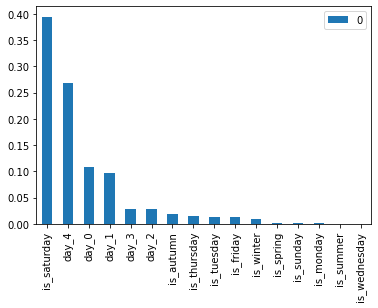

In [101]:
feat_imp.T.sort_values(0, ascending=False).plot(kind='bar')

We will compare against baselines

In [104]:
rand0_predictions = [random_model_v0(d) for d in test_X.index.tolist()]
mae_rand0 = mean_absolute_error(test_y, rand0_predictions)

In [105]:
rand1_predictions = [random_model_v1(d) for d in test_X.index.tolist()]
mae_rand1 = mean_absolute_error(test_y, rand1_predictions)

In [106]:
mean0_predictions = [mean_model_v0(d) for d in test_X.index.tolist()]
mae_mean0 = mean_absolute_error(test_y, mean0_predictions)

In [107]:
mean1_predictions = [mean_model_v1(d.strftime('%d/%m/%y')) for d in test_X.index.tolist()]
mae_mean1 = mean_absolute_error(test_y, mean1_predictions)

In [108]:
# evaluation results
pd.Series(
    {
        'RF': mae_rf,
        'Rand0': mae_rand0,
        'Rand1': mae_rand1,
        'Mean0': mae_mean0,
        'Mean1': mae_mean1
    }
).sort_values()

RF       14648.824975
Mean0    24700.248253
Mean1    25511.576012
Rand1    27884.316457
Rand0    28697.399225
dtype: float64

## Conclusion

We have developed a first solution for the givent task of predict sales for year 2012 given a dataset from 2011

The approach taken has been to first focus on understandig the problem and the dataset and then trying to model a suitable solution

The problems faced during the exploration have been:
- Not all transactions are sells, there are cancelations as well
- In general the dataset is not clean
- We have seen gaps in dates, we asumed that in these days there were no sells
- Not all invoices have a ClientID
- We haven't found any pattern on StockID that can help to cluster stock items
- Stocks have variable price, some times is 0
- We haven't seen any clear pattern in months

Other relevant observations:
- Most of the users and transactions come from the UK
- Most of the transactions have a high quantity of items
- There are no transaction on saturdays

After the exploration we have created a clean dataset to model a solution. It has been based on past 5 days data and day features such as the day of the week and season

In order to compare the results against other strategies we have created 4 baselines. We have seen that the model built improves all baselines by a large margin. This justifies the use of historical data to model sales, however these results are not valid as the MAE is too large.

The results on the modeling show that a model based on histotical data can improve simple baselines.